In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pickle.load(open('final_project/final_project_dataset.pkl'))

In [3]:
df = pd.DataFrame.from_dict(data, orient='index')

In [4]:
df = df.convert_objects(convert_numeric=True)

/home/daniel/miniconda3/envs/udacity-fraud/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


In [5]:
df['email_address'] = df['email_address'].astype('string')

In [6]:
df['email_address'] = df['email_address'].replace('NaN', np.nan)

In [7]:
df = df.drop(['THE TRAVEL AGENCY IN THE PARK', 'TOTAL'])

In [8]:
df['log_total_payments'] = np.log(df['total_payments'])

In [9]:
df['percent_to_poi'] = df['from_this_person_to_poi'] / df['from_messages']

In [10]:
df['percent_from_poi'] = df['from_poi_to_this_person'] / df['to_messages']

In [11]:
zeroed = df.fillna(0)

In [12]:
X = zeroed.drop(['poi', 'email_address'], axis=1).values
y = zeroed['poi'].values

In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier

In [49]:
import itertools

In [14]:
def plot_confusion_matrix(cm, classes, name):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(name)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
names = ['Naive Bayes', 'Random Forest', 'Gradient Boosting', 'SVM', 'Dummy']

In [16]:
clfs = [GaussianNB(),
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        LinearSVC(class_weight='balanced'),
        DummyClassifier()
       ]

In [39]:
cms = [[] for _ in clfs]

In [40]:
accuracies = [[] for _ in clfs]

In [41]:
precs = [[] for _ in clfs]

In [42]:
recs = [[] for _ in clfs]

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

In [43]:
splitter = StratifiedShuffleSplit(n_splits=1000, random_state=42)

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

In [44]:
for i, clf in enumerate(clfs):
    for train, test in splitter.split(X,y):
        clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        cm = confusion_matrix(y[test], y_pred)
        cms[i].append(cm)
        prec = precision_score(y[test], y_pred)
        rec = recall_score(y[test], y_pred)
        acc = accuracy_score(y[test], y_pred)
        precs[i].append(prec)
        recs[i].append(rec)
        accuracies[i].append(acc)

In [45]:
np_cms = np.array(cms)

In [46]:
np_cms.dtype

dtype('int64')

In [47]:
np_cms.shape

(5, 1000, 2, 2)

In [55]:
plt.rcParams['figure.figsize'] = [15, 4]

In [56]:
for i, (name, cm) in enumerate(zip(names, np_cms.mean(axis=1)),1):
    plt.subplot(1,5,i)
    plot_confusion_matrix(cm, ['False', 'True'], name)

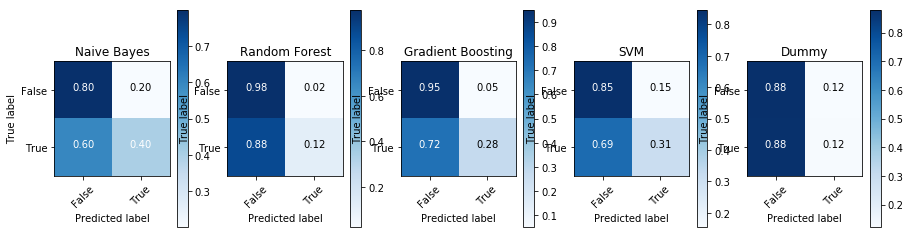

In [57]:
plt.show()

In [58]:
precs = np.array(precs)
recs = np.array(recs)
accs = np.array(accuracies)

In [59]:
for name, prec, rec, acc in zip(names, precs.mean(axis=1),
                                recs.mean(axis=1), accs.mean(axis=1)):
    print('{}: precision {}. recall {}. accuracy {}.'.format(name,prec,rec,acc))

Naive Bayes: precision 0.287772313797. recall 0.4. accuracy 0.746066666667.
Random Forest: precision 0.18395. recall 0.1195. accuracy 0.861133333333.
Gradient Boosting: precision 0.362233333333. recall 0.278. accuracy 0.859666666667.
SVM: precision 0.225286746587. recall 0.313. accuracy 0.775466666667.
Dummy: precision 0.117383333333. recall 0.125. accuracy 0.7786.


It looks like Gradient Boosting has the best overall precision/recall and accuracy. I just need to do some tweaking to get it above .3 recall

In [61]:
boost = GradientBoostingClassifier(random_state=272727)

In [62]:
from sklearn.model_selection import GridSearchCV

In [66]:
n_est_grid = GridSearchCV(boost, {'n_estimators': range(30,81,10)},
                          cv=splitter,
                          scoring=['precision', 'recall'],
                          refit=False)

In [67]:
n_est_grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=42, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=272727, subsample=1.0,
              verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [30, 40, 50, 60, 70, 80]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring=['precision', 'recall'], verbose=0)

In [68]:
n_est_grid_results = pd.DataFrame.from_dict(n_est_grid.cv_results_)

In [71]:
n_est_grid_results[['param_n_estimators', 'mean_test_recall', 'mean_test_precision']]

,param_n_estimators,mean_test_recall,mean_test_precision
0,30,0.2150,0.289367
1,40,0.2390,0.318017
2,50,0.2525,0.329317
3,60,0.2655,0.346250
4,70,0.2775,0.362733
5,80,0.2765,0.362217


Looks like 70 estimators is the way to go here

In [76]:
boost = GradientBoostingClassifier(random_state=272727, n_estimators=70)

In [77]:
max_depth_grid = GridSearchCV(boost, {'max_depth': range(5,16,2)},
                                          cv=splitter,
                                          scoring=['precision', 'recall'],
                                          refit=False)

In [78]:
max_depth_grid.fit(X,y)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=1000, random_state=42, test_size='default',
            train_size=None),
       error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=272727, subsample=1.0,
              verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 7, 9, 11, 13, 15]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring=['precision', 'recall'], verbose=0)

In [79]:
max_depth_grid_results = pd.DataFrame.from_dict(max_depth_grid.cv_results_)

In [80]:
max_depth_grid_results[['param_max_depth', 'mean_test_recall', 'mean_test_precision']]

,param_max_depth,mean_test_recall,mean_test_precision
0,5,0.2665,0.284533
1,7,0.3065,0.316583
2,9,0.3075,0.317167
3,11,0.3075,0.317167
4,13,0.3075,0.317167
5,15,0.3075,0.317167


max_depth of 9 looks great!

In [81]:
boost = GradientBoostingClassifier(random_state=272727, n_estimators=70, max_depth=9)

In [82]:
from sklearn.model_selection import train_test_split

In [84]:
boost.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=70,
              presort='auto', random_state=272727, subsample=1.0,
              verbose=0, warm_start=False)

In [85]:
boost.feature_importances_

array([ 0.00657117,  0.        ,  0.        ,  0.03132951,  0.24499973,
        0.01618141,  0.03781122,  0.14807334,  0.        ,  0.03522139,
        0.13113927,  0.        ,  0.00167114,  0.16296841,  0.00147228,
        0.        ,  0.        ,  0.02132769,  0.        ,  0.02776374,
        0.13288702,  0.00058267])

In [89]:
pd.DataFrame(boost.feature_importances_, columns=['score'], index=zeroed.drop(['poi', 'email_address'], axis=1).columns).sort_values('score', ascending=False)

,score
exercised_stock_options,0.245000
other,0.162968
shared_receipt_with_poi,0.148073
percent_to_poi,0.132887
expenses,0.131139
restricted_stock,0.037811
total_stock_value,0.035221
total_payments,0.031330
log_total_payments,0.027764
long_term_incentive,0.021328


In [90]:
_.to_clipboard()

In [91]:
X.shape

(144, 22)